# 영어에서 프랑스어로 번역하기

## 방법 1. Googletrans 사용하기

In [1]:
# !pip install googletrans==4.0.0-rc1

In [2]:
from googletrans import Translator

In [3]:
translator = Translator()

In [4]:
sentence_en = "it was a mistake."

In [5]:
sentence_fra = translator.translate(sentence_en, dest='fr')

In [6]:
print('번역 전 영어 문장: {}'.format(sentence_en))
print('번역 후 프랑스어 문장: {}'.format(sentence_fra.text))

번역 전 영어 문장: it was a mistake.
번역 후 프랑스어 문장: c'était une erreur.


## 방법 2. seq2seq를 이용하여 번역기 생성하기

### 01. 데이터 로드 및 전처리

#### 사용할 라이브러리 추가

In [7]:
import os
import re
import shutil
import zipfile

import numpy as np
import pandas as pd
import tensorflow as tf
import unicodedata
import urllib3
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

#### 압축 파일 다운로드 후 압축 풀기

In [8]:
http = urllib3.PoolManager()
url = 'http://www.manythings.org/anki/fra-eng.zip'
filename = 'fra-eng.zip'
path = os.getcwd() + "/data"
zipfilename = os.path.join(path, filename)
with http.request('GET', url, preload_content=False) as r, open(zipfilename, 'wb') as out_file:
    shutil.copyfileobj(r, out_file)

with zipfile.ZipFile(zipfilename, 'r') as zip_ref:
    zip_ref.extractall(path)

#### 사용할 샘플 정의

In [9]:
num_samples = 80000

#### 전처리 함수 정의

In [10]:
def to_ascii(s):
    # 프랑스어 악센트(accent) 삭제
    # 예시 : 'déjà diné' -> deja dine
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')

In [11]:
def preprocess_sentence(sent):
    # 악센트 제거 함수 호출
    sent = to_ascii(sent.lower())

    # 단어와 구두점 사이에 공백 추가.
    # ex) "I am a student." => "I am a student ."
    sent = re.sub(r"([?.!,¿])", r" \1", sent)

    # (a-z, A-Z, ".", "?", "!", ",") 이들을 제외하고는 전부 공백으로 변환.
    sent = re.sub(r"[^a-zA-Z!.?]+", r" ", sent)

    # 다수 개의 공백을 하나의 공백으로 치환
    sent = re.sub(r"\s+", " ", sent)
    return sent

#### 전처리 테스트

In [12]:
en_sent = u"Have you had dinner?"
fr_sent = u"Avez-vous déjà diné?"

print('전처리 전 영어 문장 :', en_sent)
print('전처리 후 영어 문장 :',preprocess_sentence(en_sent))
print('전처리 전 프랑스어 문장 :', fr_sent)
print('전처리 후 프랑스어 문장 :', preprocess_sentence(fr_sent))

전처리 전 영어 문장 : Have you had dinner?
전처리 후 영어 문장 : have you had dinner ?
전처리 전 프랑스어 문장 : Avez-vous déjà diné?
전처리 후 프랑스어 문장 : avez vous deja dine ?


#### 입력 시퀸스, 종료 시퀸스에 토큰 추가

In [13]:
def load_preprocessed_data():
    encoder_input, decoder_input, decoder_target = [], [], []

    with open(path+"/fra.txt", "r",encoding='utf-8') as lines:
        for i, line in enumerate(lines):
            # source 데이터와 target 데이터 분리
            src_line, tar_line, _ = line.strip().split('\t')

            # source 데이터 전처리
            src_line = [w for w in preprocess_sentence(src_line).split()]

            # target 데이터 전처리
            tar_line = preprocess_sentence(tar_line)
            tar_line_in = [w for w in ("<sos> " + tar_line).split()]
            tar_line_out = [w for w in (tar_line + " <eos>").split()]

            encoder_input.append(src_line)
            decoder_input.append(tar_line_in)
            decoder_target.append(tar_line_out)

            if i == num_samples - 1:
                break

    return encoder_input, decoder_input, decoder_target

#### 3개의 데이터셋 인코더의 입력, 디코더의 입력, 디코더의 레이블 상위 5개 샘플만 출력

In [14]:
sents_en_in, sents_fra_in, sents_fra_out = load_preprocessed_data()
print('인코더의 입력 :',sents_en_in[:5])
print('디코더의 입력 :',sents_fra_in[:5])
print('디코더의 레이블 :',sents_fra_out[:5])

인코더의 입력 : [['go', '.'], ['go', '.'], ['go', '.'], ['hi', '.'], ['hi', '.']]
디코더의 입력 : [['<sos>', 'va', '!'], ['<sos>', 'marche', '.'], ['<sos>', 'bouge', '!'], ['<sos>', 'salut', '!'], ['<sos>', 'salut', '.']]
디코더의 레이블 : [['va', '!', '<eos>'], ['marche', '.', '<eos>'], ['bouge', '!', '<eos>'], ['salut', '!', '<eos>'], ['salut', '.', '<eos>']]


#### 토크나이저를 통해 단어 집합 생성, 정수 인코딩 진행 후 패딩 진행

In [15]:
tokenizer_en = Tokenizer(filters="", lower=False)
tokenizer_en.fit_on_texts(sents_en_in)
encoder_input = tokenizer_en.texts_to_sequences(sents_en_in)
encoder_input = pad_sequences(encoder_input, padding="post")

tokenizer_fra = Tokenizer(filters="", lower=False)
tokenizer_fra.fit_on_texts(sents_fra_in)
tokenizer_fra.fit_on_texts(sents_fra_out)

decoder_input = tokenizer_fra.texts_to_sequences(sents_fra_in)
decoder_input = pad_sequences(decoder_input, padding="post")

decoder_target = tokenizer_fra.texts_to_sequences(sents_fra_out)
decoder_target = pad_sequences(decoder_target, padding="post")

In [16]:
print('인코더의 입력의 크기(shape) :',encoder_input.shape)
print('디코더의 입력의 크기(shape) :',decoder_input.shape)
print('디코더의 레이블의 크기(shape) :',decoder_target.shape)

인코더의 입력의 크기(shape) : (80000, 9)
디코더의 입력의 크기(shape) : (80000, 17)
디코더의 레이블의 크기(shape) : (80000, 17)


In [17]:
src_vocab_size = len(tokenizer_en.word_index) + 1
tar_vocab_size = len(tokenizer_fra.word_index) + 1
print("영어 단어 집합의 크기 : {:d}, 프랑스어 단어 집합의 크기 : {:d}".format(src_vocab_size, tar_vocab_size))

영어 단어 집합의 크기 : 7767, 프랑스어 단어 집합의 크기 : 13199


#### 순서가 섞인 정수 시퀀스 리스트 생성

In [18]:
src_to_index = tokenizer_en.word_index
index_to_src = tokenizer_en.index_word
tar_to_index = tokenizer_fra.word_index
index_to_tar = tokenizer_fra.index_word

In [19]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print('랜덤 시퀀스 :',indices)

랜덤 시퀀스 : [ 4165 24669 50297 ... 18584 25527 60925]


In [20]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

#### 훈련 데이터 테스트 데이터 분리

In [21]:
n_of_val = int(num_samples*0.1)
print('검증 데이터의 개수 :',n_of_val)

검증 데이터의 개수 : 8000


In [22]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [23]:
print('훈련 source 데이터의 크기 :',encoder_input_train.shape)
print('훈련 target 데이터의 크기 :',decoder_input_train.shape)
print('훈련 target 레이블의 크기 :',decoder_target_train.shape)
print('테스트 source 데이터의 크기 :',encoder_input_test.shape)
print('테스트 target 데이터의 크기 :',decoder_input_test.shape)
print('테스트 target 레이블의 크기 :',decoder_target_test.shape)

훈련 source 데이터의 크기 : (72000, 9)
훈련 target 데이터의 크기 : (72000, 17)
훈련 target 레이블의 크기 : (72000, 17)
테스트 source 데이터의 크기 : (8000, 9)
테스트 target 데이터의 크기 : (8000, 17)
테스트 target 레이블의 크기 : (8000, 17)


### 02. 기계 번역기 만들기

In [24]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

#### 임베딩 벡터의 차원과 LSTM의 은닉 상태의 크기 정의

In [25]:
embedding_dim = 64
hidden_units = 64

#### 인코더 설계

In [26]:
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(src_vocab_size, embedding_dim)(encoder_inputs) # 임베딩 층
enc_masking = Masking(mask_value=0.0)(enc_emb) # 패딩 0은 연산에서 제외
encoder_lstm = LSTM(hidden_units, return_state=True) # 상태값 리턴을 위해 return_state는 True
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking) # 은닉 상태와 셀 상태를 리턴
encoder_states = [state_h, state_c] # 인코더의 은닉 상태와 셀 상태를 저장

#### 디코더 설계

In [27]:
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(tar_vocab_size, hidden_units) # 임베딩 층
dec_emb = dec_emb_layer(decoder_inputs) # 패딩 0은 연산에서 제외
dec_masking = Masking(mask_value=0.0)(dec_emb)

# 상태값 리턴을 위해 return_state는 True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequences는 True
decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True) 

# 인코더의 은닉 상태를 초기 은닉 상태(initial_state)로 사용
decoder_outputs, _, _ = decoder_lstm(dec_masking,
                                     initial_state=encoder_states)

# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
decoder_dense = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

#### 모델의 입력과 출력 정의

In [28]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

#### 모델 훈련

In [29]:
translator_seq2seq = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train,
                       validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
                       batch_size=128, epochs=50)

Epoch 1/50
563/563 [==============================] - 270s 458ms/step - loss: 2.7886 - acc: 0.6263 - val_loss: 1.9188 - val_acc: 0.7069
Epoch 2/50
563/563 [==============================] - 263s 467ms/step - loss: 1.7740 - acc: 0.7226 - val_loss: 1.6647 - val_acc: 0.7312
Epoch 3/50
563/563 [==============================] - 259s 460ms/step - loss: 1.5790 - acc: 0.7426 - val_loss: 1.4943 - val_acc: 0.7648
Epoch 4/50
563/563 [==============================] - 253s 449ms/step - loss: 1.4076 - acc: 0.7709 - val_loss: 1.3562 - val_acc: 0.7795
Epoch 5/50
563/563 [==============================] - 254s 451ms/step - loss: 1.2800 - acc: 0.7876 - val_loss: 1.2538 - val_acc: 0.7949
Epoch 6/50
563/563 [==============================] - 253s 449ms/step - loss: 1.1788 - acc: 0.8010 - val_loss: 1.1786 - val_acc: 0.8043
Epoch 7/50
563/563 [==============================] - 254s 451ms/step - loss: 1.0971 - acc: 0.8108 - val_loss: 1.1157 - val_acc: 0.8113
Epoch 8/50
563/563 [============================

#### 모델 정확도

In [30]:
import matplotlib.pyplot as plt

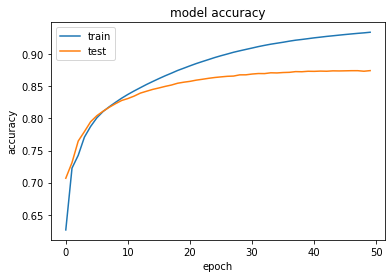

In [32]:
plt.plot(translator_seq2seq.history['acc'])
plt.plot(translator_seq2seq.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

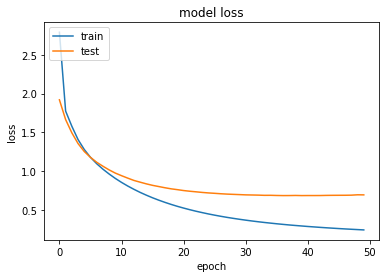

In [33]:
plt.plot(translator_seq2seq.history['loss'])
plt.plot(translator_seq2seq.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 03. 기계 번역기 사용하기

#### 인코더

In [34]:
encoder_model = Model(encoder_inputs, encoder_states)

#### 디코더

In [35]:
# 이전 시점의 상태를 보관할 텐서
decoder_state_input_h = Input(shape=(hidden_units,))
decoder_state_input_c = Input(shape=(hidden_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

In [36]:
# 훈련 때 사용했던 임베딩 층을 재사용
dec_emb2 = dec_emb_layer(decoder_inputs)

In [37]:
# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

In [38]:
# 모든 시점에 대해서 단어 예측
decoder_outputs2 = decoder_dense(decoder_outputs2)

In [39]:
# 수정된 디코더
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

#### 문장이 인코더 ~ 디코더를 거치는 과정을 함수로 정의

In [41]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 마지막 시점의 상태(은닉 상태, 셀 상태)를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 정수 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_to_index['<sos>']

    stop_condition = False
    decoded_sentence = ''

    # stop_condition이 True가 될 때까지 루프 반복
    # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 단어로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_tar[sampled_token_index]

        # 현재 시점의 예측 단어를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
        if (sampled_char == '<eos>' or
            len(decoded_sentence) > 50):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

#### 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수 정의

In [43]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_src(input_seq):
    sentence = ''
    for encoded_word in input_seq:
        if(encoded_word != 0):
            sentence = sentence + index_to_src[encoded_word] + ' '
    return sentence

In [44]:
# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_tar(input_seq):
    sentence = ''
    for encoded_word in input_seq:
        if(encoded_word != 0 and encoded_word != tar_to_index['<sos>'] and encoded_word != tar_to_index['<eos>']):
            sentence = sentence + index_to_tar[encoded_word] + ' '
    return sentence

#### 임의로 선택한 인덱스의 샘플 결과 출력

In [45]:
# 훈련데이터에서 선택한 경우
seq_index = 300
input_seq = encoder_input_train[seq_index: seq_index + 1]
decoded_sentence = decode_sequence(input_seq)

1/1 [==============================] - 0s 21ms/step


In [52]:
print("입력문장 :",seq_to_src(encoder_input_train[seq_index]))
print("정답문장 :",seq_to_tar(decoder_input_train[seq_index]))
print("번역문장 :",decoded_sentence[1:-5])

입력문장 : tom kissed his cousin . 
정답문장 : tom embrassa sa cousine . 
번역문장 : vous n etes pas grosse . 


In [49]:
# 테스트 데이터에서 선택한 경우
seq_index = 300
input_seq = encoder_input_test[seq_index: seq_index + 1]
decoded_sentence = decode_sequence(input_seq)

1/1 [==============================] - 0s 18ms/step


In [51]:
print("입력문장 :",seq_to_src(encoder_input_test[seq_index]))
print("정답문장 :",seq_to_tar(decoder_input_test[seq_index]))
print("번역문장 :",decoded_sentence[1:-5])

입력문장 : you re not fat . 
정답문장 : vous n etes pas gros . 
번역문장 : vous n etes pas grosse . 


## 방법 1과 방법 2 비교하기

In [53]:
sentence_en = "you re not fat ."
sentence_fra = translator.translate(sentence_en, dest='fr')
print(sentence_en + '이라는 문장을 방법 1로 번역하면 {}'.format(sentence_fra.text) + 
      '가 되고 방법 2로 번역하면 {}'.format(decoded_sentence[1:-5]) + '이다.')

you re not fat .이라는 문장을 방법 1로 번역하면 tu n'es pas gros.가 되고 방법 2로 번역하면 vous n etes pas grosse . 이다.


In [54]:
from IPython.display import Image

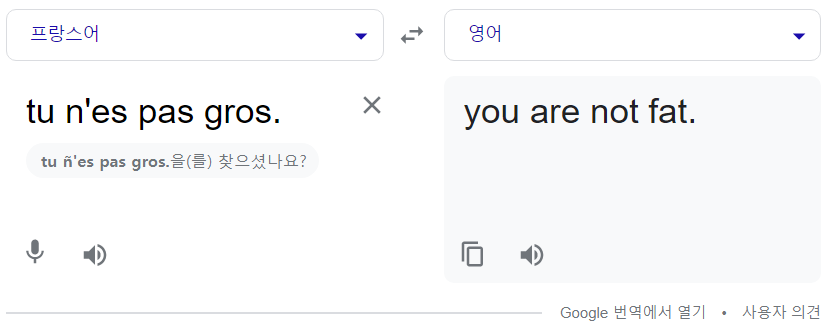

In [59]:
Image('./image/001.png', width = 600, height = 400)

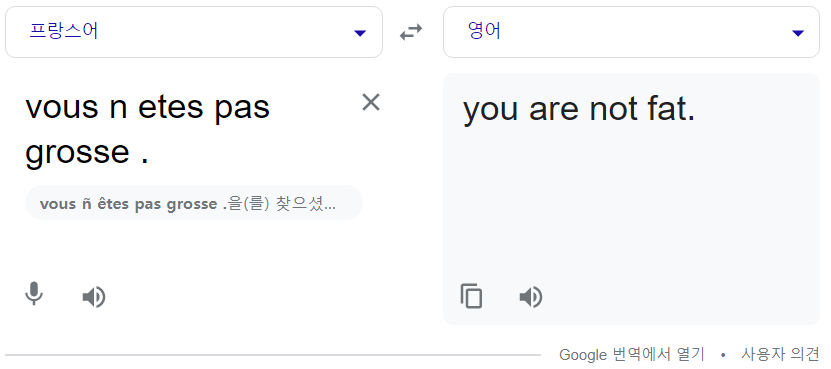

In [60]:
Image('./image/002.png', width = 600, height = 400)